In [31]:
# Front matter
import os,datetime
import pandas as pd
import numpy as np
import scipy
from scipy import constants
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
from matplotlib import gridspec
import re

# Seaborn, useful for graphics
import seaborn as sns

# Magic function to make matplotlib inline; other style specs must come AFTER
%matplotlib inline

matplotlib.rc('xtick', labelsize=16) 
matplotlib.rc('ytick', labelsize=16) 

rc = {'lines.linewidth': 1, 
      'axes.labelsize': 20, 
      'axes.titlesize': 20,
      'legend.fontsize': 26,
      'xtick.direction': u'in',
      'ytick.direction': u'in'}
sns.set_style('ticks', rc=rc)

In [32]:
# Import data sets
studylist = []
labelchoice = dict()
phase = dict()
NRIXSdatapath = dict()
XRDdatapath = dict()
colorchoice = dict()
mfcchoice = dict()
symbol = dict()
symbolsize = dict()

study = 'bccFe_pdf_Debye'
studylist.append(study)
labelchoice[study] = 'bcc Fe (Debye, pdf)'
phase[study] = 'bcc'
NRIXSdatapath[study] = '../080_vD_Fe_Debye/Results/vD_results_Debye.csv'
XRDdatapath[study]   = '../010_XRDAnalysis/Results/XRD_results_bccFe.csv'
colorchoice[study] = 'DeepSkyBlue'
mfcchoice[study] = None # Filled
symbol[study] = '^'
symbolsize[study] = 9

study = 'bccFe_pdf_PowerLaw'
studylist.append(study)
labelchoice[study] = 'bcc Fe (power law, pdf)'
phase[study] = 'bcc'
NRIXSdatapath[study] = '../081_vD_Fe_PowerLaw/Results/vD_results_Constrained_Power.csv'
XRDdatapath[study]   = '../010_XRDAnalysis/Results/XRD_results_bccFe.csv'
colorchoice[study] = 'Green'
mfcchoice[study] = None # Filled
symbol[study] = '^'
symbolsize[study] = 9

study = 'hcpFe_Murphy'
studylist.append(study)
labelchoice[study] = 'hcp Fe (Murphy et al. 2013, Debye)'
phase[study] = 'hcp'
NRIXSdatapath[study] = '../005_PubNRIXSVals/hcpFe_Murphy.csv'
XRDdatapath[study]   = '../005_PubNRIXSVals/hcpFe_Murphy.csv'
colorchoice[study] = 'Black'
mfcchoice[study] = None # Filled
symbol[study] = 'o'
symbolsize[study] = 8

study = 'hcpFe_Murphy_pdf_Debye'
studylist.append(study)
labelchoice[study] = 'hcp Fe (Debye, pdf)'
phase[study] = 'hcp'
NRIXSdatapath[study] = '../080_vD_Fe_Debye/Results/vD_results_Debye.csv'
XRDdatapath[study]   = '../005_PubNRIXSVals/hcpFe_Murphy.csv'
colorchoice[study] = 'DeepSkyBlue'
mfcchoice[study] = None # Filled
symbol[study] = 'o'
symbolsize[study] = 8

study = 'hcpFe_Murphy_pdf_PowerLaw'
studylist.append(study)
labelchoice[study] = 'hcp Fe (power law, pdf)'
phase[study] = 'hcp'
NRIXSdatapath[study] = '../081_vD_Fe_PowerLaw/Results/vD_results_Constrained_Power.csv'
XRDdatapath[study]   = '../005_PubNRIXSVals/hcpFe_Murphy.csv'
colorchoice[study] = 'Green'
mfcchoice[study] = None # Filled
symbol[study] = 'o'
symbolsize[study] = 8

In [38]:
precious_dfdict = dict()

for study in studylist:
    print('Now importing '+study)

    # Import XRD data
    init_XRD_df = pd.read_csv(XRDdatapath[study])
    # Change index name to match other data sets
    if 'NRIXS exp' in init_XRD_df:
        init_XRD_df = init_XRD_df.rename(columns={'NRIXS exp': 'Index'})
    # We only need some of the info here
    if phase[study] == 'bcc':
        XRD_df = init_XRD_df[['Index','a','da','V','dV','rho','drho','P','dP']]
    else:
        XRD_df = init_XRD_df[['Index','a','da','c','dc','V','dV','rho','drho','P','dP']]

    # Import NRIXS data
    init_NRIXS_df = pd.read_csv(NRIXSdatapath[study])
    # We're only going to look at some of the values here, b/c only some values are reported in all dataframes
    NRIXS_df = init_NRIXS_df[['Index','vD','dvD','vP','dvP','vS','dvS']]
#     NRIXS_df = init_NRIXS_df[['Index','vD','dvD']]
    # Get rows in NRIXS df that also appear in XRD df. (So we only look at bcc or hcp data.)
    NRIXS_df = NRIXS_df[NRIXS_df['Index'].isin(XRD_df['Index'].values)]
    
    # Change units of Murphy data
    if study == 'hcpFe_Murphy':
        NRIXS_df[['vD','dvD','vP','dvP','vS','dvS']] = NRIXS_df[['vD','dvD','vP','dvP','vS','dvS']]*1000
#         NRIXS_df[['vD','dvD']] = NRIXS_df[['vD','dvD']]*1000
    
    # Combine XRD df and NRIXS df into one df to rule them all
    precious_df = pd.merge(XRD_df,NRIXS_df,on='Index')

    precious_dfdict[study] = precious_df

Now importing bccFe_pdf_Debye
Now importing bccFe_pdf_PowerLaw
Now importing hcpFe_Murphy
Now importing hcpFe_Murphy_pdf_Debye
Now importing hcpFe_Murphy_pdf_PowerLaw


In [39]:
alphaval = 0.75

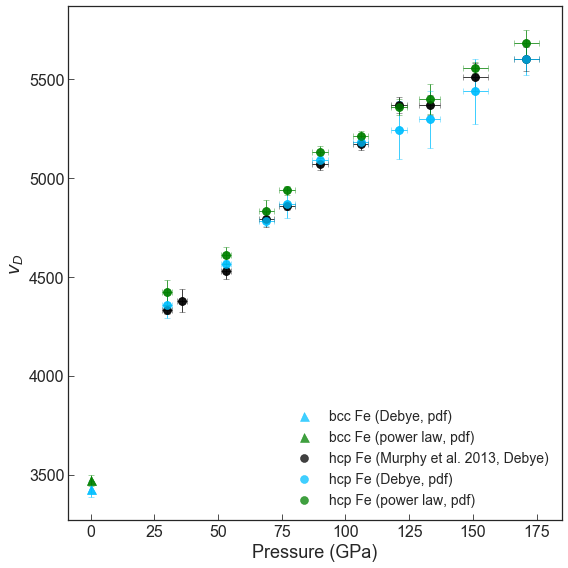

In [40]:
# Debye velocity: The Debye model from the pdf is the most statistically meaningful
studylist_crop = ['bccFe_pdf_Debye',
                  'bccFe_pdf_PowerLaw',
                  'hcpFe_Murphy',
                  'hcpFe_Murphy_pdf_Debye',
                  'hcpFe_Murphy_pdf_PowerLaw']

fig, (ax0) = plt.subplots(nrows = 1, ncols=1, sharex=True, figsize=(8, 8))

hlabels = []
for study in studylist_crop:
    df = precious_dfdict[study]

    h, = ax0.plot(df['P'], df['vD'], marker=symbol[study], ms=symbolsize[study], color=colorchoice[study],
                   mfc=mfcchoice[study],  alpha = alphaval,
                   label=labelchoice[study],markeredgewidth=0.5,ls='none')

    ax0.errorbar(df['P'], df['vD'], xerr=df['dP'], yerr=df['dvD'], alpha = alphaval,
                 marker=symbol[study], ms=symbolsize[study], capsize=3, color=colorchoice[study], 
                 mfc=mfcchoice[study],
                 label=labelchoice[study],markeredgewidth=0.5,ls='none',elinewidth=1)
    
    hlabels.append(h)

# df1 = precious_dfdict['hcpFe_Murphy_pdf_Debye']
# df2 = precious_dfdict['hcpFe_Murphy_pdf_Unconst']
# ax0.plot(df1['P'], (df1['V_D']+df2['V_D'])/2, marker=symbol[study], ms=symbolsize[study], color='black',
#                    mfc=mfcchoice[study],  alpha = alphaval,
#                    label='average',markeredgewidth=0.5,ls='none')

# hlabels = [h0, h1, h2, h3, h4]
ax0.legend(fontsize=14,loc=4,handles = hlabels)

ax0.set_xlabel(r'Pressure (GPa)', fontsize=18)
ax0.set_ylabel(r'$v_{D}$', fontsize=18)


plt.tight_layout()

fig = plt.gcf()
fig.savefig('hcpFe_vD.pdf', format='pdf')

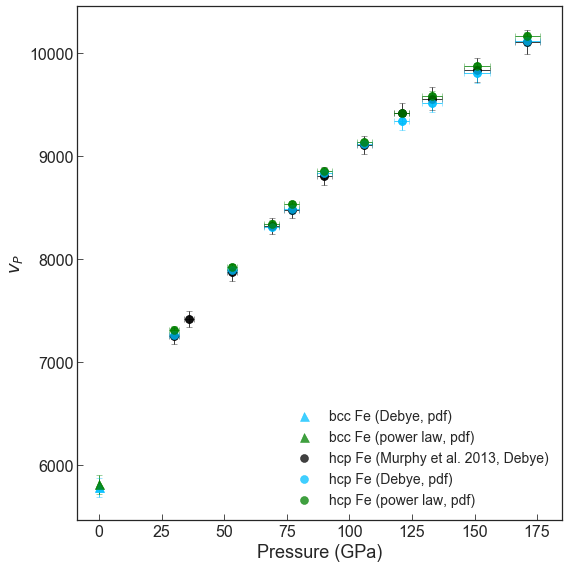

In [41]:
# Debye velocity: The Debye model from the pdf is the most statistically meaningful
studylist_crop = ['bccFe_pdf_Debye',
                  'bccFe_pdf_PowerLaw',
                  'hcpFe_Murphy',
                  'hcpFe_Murphy_pdf_Debye',
                  'hcpFe_Murphy_pdf_PowerLaw']

fig, (ax0) = plt.subplots(nrows = 1, ncols=1, sharex=True, figsize=(8, 8))

hlabels = []
for study in studylist_crop:
    df = precious_dfdict[study]

    h, = ax0.plot(df['P'], df['vP'], marker=symbol[study], ms=symbolsize[study], color=colorchoice[study],
                   mfc=mfcchoice[study],  alpha = alphaval,
                   label=labelchoice[study],markeredgewidth=0.5,ls='none')

    ax0.errorbar(df['P'], df['vP'], xerr=df['dP'], yerr=df['dvP'], alpha = alphaval,
                 marker=symbol[study], ms=symbolsize[study], capsize=3, color=colorchoice[study], 
                 mfc=mfcchoice[study],
                 label=labelchoice[study],markeredgewidth=0.5,ls='none',elinewidth=1)
    
    hlabels.append(h)

# df1 = precious_dfdict['hcpFe_Murphy_pdf_Debye']
# df2 = precious_dfdict['hcpFe_Murphy_pdf_Unconst']
# ax0.plot(df1['P'], (df1['V_D']+df2['V_D'])/2, marker=symbol[study], ms=symbolsize[study], color='black',
#                    mfc=mfcchoice[study],  alpha = alphaval,
#                    label='average',markeredgewidth=0.5,ls='none')

# hlabels = [h0, h1, h2, h3, h4]
ax0.legend(fontsize=14,loc=4,handles = hlabels)

ax0.set_xlabel(r'Pressure (GPa)', fontsize=18)
ax0.set_ylabel(r'$v_{P}$', fontsize=18)


plt.tight_layout()

fig = plt.gcf()
fig.savefig('hcpFe_vP.pdf', format='pdf')

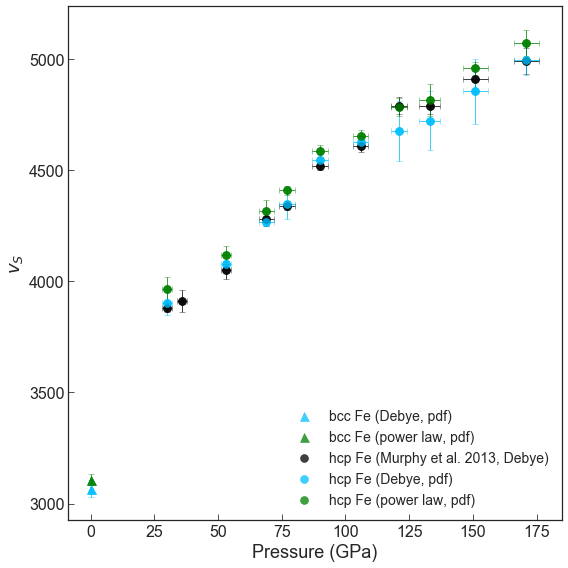

In [42]:
# Debye velocity: The Debye model from the pdf is the most statistically meaningful
studylist_crop = ['bccFe_pdf_Debye',
                  'bccFe_pdf_PowerLaw',
                  'hcpFe_Murphy',
                  'hcpFe_Murphy_pdf_Debye',
                  'hcpFe_Murphy_pdf_PowerLaw']

fig, (ax0) = plt.subplots(nrows = 1, ncols=1, sharex=True, figsize=(8, 8))

hlabels = []
for study in studylist_crop:
    df = precious_dfdict[study]

    h, = ax0.plot(df['P'], df['vS'], marker=symbol[study], ms=symbolsize[study], color=colorchoice[study],
                   mfc=mfcchoice[study],  alpha = alphaval,
                   label=labelchoice[study],markeredgewidth=0.5,ls='none')

    ax0.errorbar(df['P'], df['vS'], xerr=df['dP'], yerr=df['dvS'], alpha = alphaval,
                 marker=symbol[study], ms=symbolsize[study], capsize=3, color=colorchoice[study], 
                 mfc=mfcchoice[study],
                 label=labelchoice[study],markeredgewidth=0.5,ls='none',elinewidth=1)
    
    hlabels.append(h)

# df1 = precious_dfdict['hcpFe_Murphy_pdf_Debye']
# df2 = precious_dfdict['hcpFe_Murphy_pdf_Unconst']
# ax0.plot(df1['P'], (df1['V_D']+df2['V_D'])/2, marker=symbol[study], ms=symbolsize[study], color='black',
#                    mfc=mfcchoice[study],  alpha = alphaval,
#                    label='average',markeredgewidth=0.5,ls='none')

# hlabels = [h0, h1, h2, h3, h4]
ax0.legend(fontsize=14,loc=4,handles = hlabels)

ax0.set_xlabel(r'Pressure (GPa)', fontsize=18)
ax0.set_ylabel(r'$v_{S}$', fontsize=18)


plt.tight_layout()

fig = plt.gcf()
fig.savefig('hcpFe_vS.pdf', format='pdf')